#### 0) Lectura de datos

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes as bfh
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops
from tabulate import tabulate
import pytesseract
import math

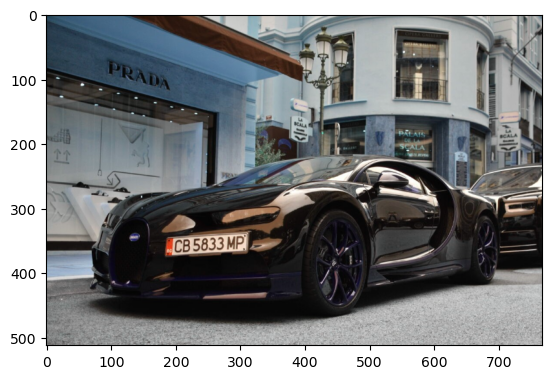

In [2]:
# Cargar la imagen 'auto_1.jpg' con opencv
imagen = cv2.imread('images/auto_1.jpg')

# Convertir la imagen a formato RGB
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Redimensionar la imagen mediante el método de opencv "resize()" a un tamaño de (768,512)
imagen_redimensionada = cv2.resize(imagen, (768, 512))

# Visualizar la imagen
plt.imshow(imagen_redimensionada)
plt.show()


#### 1) Detección de bordes con Canny

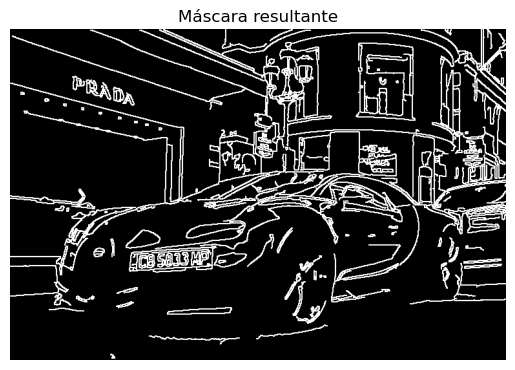

In [3]:
# Aplicar un filtro gaussiano con un kernel de 3x3
imagen_filtrada = cv2.GaussianBlur(imagen_redimensionada, (3, 3), 0)

# Aplicar el método de Canny para la detección de bordes
bordes_canny = cv2.Canny(imagen_filtrada, 255/3, 255)

# Aplicar una dilatación con un kernel de 2x2 y 1 iteración
kernel = np.ones((2, 2), 'uint8')
bordes_canny = cv2.dilate(bordes_canny, kernel, iterations=1)

# Visualizar la máscara resultante
plt.imshow(bordes_canny, cmap='gray')
plt.title('Máscara resultante')
plt.axis('off')
plt.show()

#### 2) Procesamiento mediante operaciones morfológicas

In [4]:
# Aplicar el comando "binary_fill_holes" sobre los bordes detectados.
# Nota: convertir la imagen a formato "uint8"
bordes_canny = bfh(bordes_canny)

In [5]:
# Convertir la imagen a formato uint8
bordes_canny = np.uint8(bordes_canny)

In [6]:
# Aplicar una apertura en el eje vertical con un kernel de 20x1 y 1 iteración para eliminar bordes verticales. 
# Nota: Aplicar el método de opencv "morphologyEx()" con cv2.MORPH_OPEN. 
kernel_vertical = np.ones((20, 1), 'uint8')
bordes_canny = cv2.morphologyEx(bordes_canny, cv2.MORPH_OPEN, kernel_vertical, iterations=1)

# Aplicar una apertura en el eje horizontal con un kernel de 1x20 y 1 iteración para eliminar bordes horizontales
kernel_horizontal = np.ones((1, 20), 'uint8')
bordes_canny = cv2.morphologyEx(bordes_canny, cv2.MORPH_OPEN, kernel_horizontal, iterations=1)

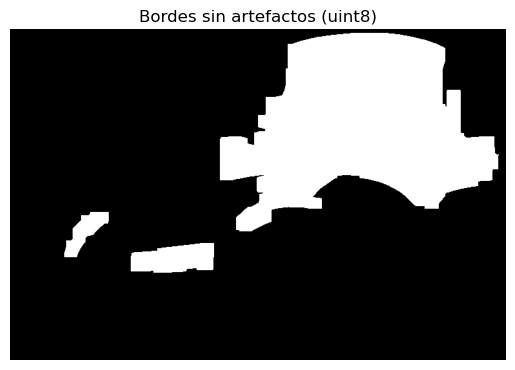

In [7]:
# Eliminar artefactos, es decir, objetos cuya área tenga menos de 1000 píxeles con una connectivity=8.  
# Nota: utilizar el método "remove_small_objects()" sobre la máscara anterior en formato booleano. 
bordes_canny = remove_small_objects(bordes_canny.astype(bool), min_size=1000, connectivity=8)

# Convertir la máscara resultante a formato uint8
bordes_canny = np.uint8(bordes_canny)

# Visualizar la máscara resultante
plt.imshow(bordes_canny, cmap='gray')
plt.title('Bordes sin artefactos (uint8)')
plt.axis('off')
plt.show()

#### 3) Detección automática de la región de interés correspondiente a la matrícula

In [8]:
# Crear una imagen de etiquetas mediante el comando "label"
lab, num = label(bordes_canny, return_num=True)

In [9]:
# Calcular la proporción (cociente) entre el minor_axis_length y el major_axis_length para cada objeto de la imagen de etiquetas
headers = ['','Label_1', 'Label_2', 'Label_3']
MA,MiA,CO = ['major_axis'], ['minor_axis'], ['cociente']

for i in range(1,num+1):
    # Cramos una matriz booleana de la imagen para cada label
    objeto = lab == i
    prop = regionprops(objeto.astype(np.uint8))
    MA.append(np.round(prop[0].major_axis_length, 4))
    MiA.append(np.round(prop[0].minor_axis_length, 4))
    CO.append(np.round(prop[0].minor_axis_length/prop[0].major_axis_length, 4))

my_data = [tuple(MA), tuple(MiA), tuple(CO)]

print(tabulate(my_data, headers=headers))

              Label_1    Label_2    Label_3
----------  ---------  ---------  ---------
major_axis   412.61      98.026    145.481
minor_axis   284.653     32.5333    43.6336
cociente       0.6899     0.3319     0.2999


In [10]:
# Generar una máscara que contenga únicamente el objeto de la menor proporción. 
mascara = lab == 3
mascara = mascara.astype('uint8')

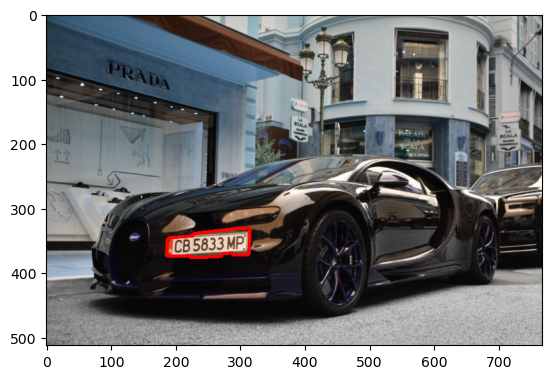

In [11]:
# Visualizar el contorno de la mascara sobre la imagen original
contorno_mascara, _ = cv2.findContours(mascara, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image = cv2.drawContours(imagen_redimensionada.copy(), contorno_mascara, -1, (255, 0, 0), 3)
plt.imshow(image, cmap='gray')
plt.show()

#### 4) Procesamiento de la región de interés

(331, 187, 377, 316)
(187, 331)
(316, 377)


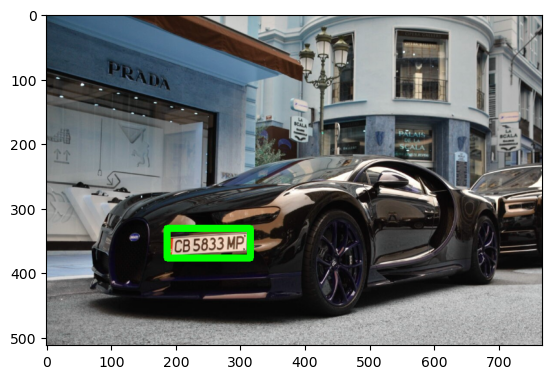

In [12]:
# Calcular la boundingbox de la máscara
bbox = prop[0].bbox
print(bbox)
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])
print(start_point)
print(end_point)
window = cv2.rectangle(imagen_redimensionada.copy(), start_point, end_point, (0, 255, 0), 10)                     
plt.imshow(window, cmap='gray')
plt.show()

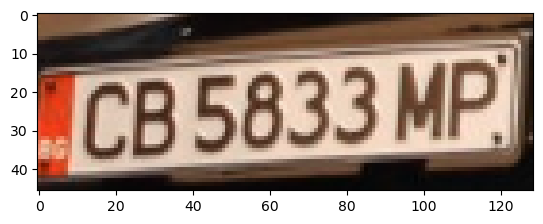

In [13]:
# Hacer un crop de la imagen original a partir de las coordenadas de la boundingbox
imagen_cortada = imagen_redimensionada[bbox[0]:bbox[2], bbox[1]:bbox[3]]
plt.imshow(imagen_cortada, cmap='gray')
plt.show()

In [14]:
# Calcular la orientación de la máscara. 
orientacion = np.round(prop[0].orientation, 4)

In [15]:
# Hacer una conversión mediante la siguiente fórmula:
angulo = (orientacion * 90)/(math.pi / 2)
if angulo > 0:
    angulo_convertido = 90 - angulo
else:
    angulo_convertido = -(90 + angulo)

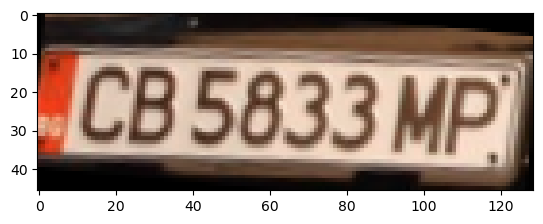

In [16]:
# Aplicar una transformación geométrica de rotación para orientar horizontalmente el crop de la imagen obtenido anteriormente
filas, columnas, ch = imagen_cortada.shape
matriz_rotacion = cv2.getRotationMatrix2D((columnas/2, filas/2), angle=angulo_convertido, scale=1) 
imagen_cortada = cv2.warpAffine(imagen_cortada, matriz_rotacion, (columnas, filas))
plt.imshow(imagen_cortada, cmap='gray')
plt.show()

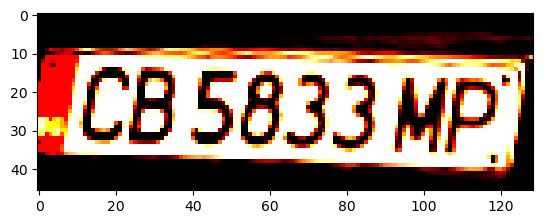

In [17]:
# Aumentar el contraste 100 unidades de acuerdo a la fórmula vista en clase. 
# Visualizar el resultado la matrícula con el contraste aumentado
contraste = 100
f = 131*(contraste + 127)/(127*(131-contraste))
alpha_c = f
gamma_c = 127*(1-f)
imagen_contraste = cv2.addWeighted(imagen_cortada, alpha_c, imagen_cortada, 0, gamma_c)
plt.imshow(imagen_contraste, cmap='gray')
plt.show()

#### 5) Convertir el contenido de la imagen en un string mediante la librería 'pytesseract'
Para instalar la librería pytesseract:
    
    Descargar el ejecutable en -->  https://github.com/UB-Mannheim/tesseract/wiki
    Instalar la librería haciendo --> pip install pytesseract

Si se tienen dudas, consultar el siguiente vídeo:

    https://www.youtube.com/watch?v=_j6o2rBkhhg

In [18]:
# Crear la ruta de pytesseract que contenga el ejecutable
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\djper\AppData\Local\Programs\Tesseract-OCR\tesseract'

# Convertir el contenido de la imagen en una variable de tipo string.
# Importante: utiliza la opción --> config='--psm 10'
texto_extraido = pytesseract.image_to_string(imagen_contraste, config='--psm 10')

# Eliminar del string los caracteres especiales mediante la siguiente línea de código:
# string = ''.join(filter(str.isalnum, string))
texto_limpio = ''.join(filter(str.isalnum, texto_extraido))
print(texto_limpio)

CB5833MP


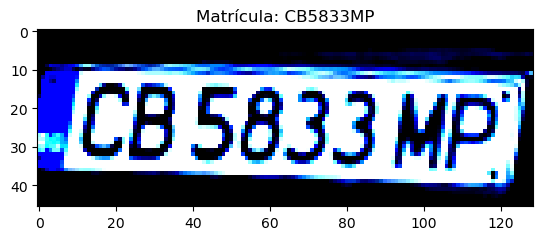

In [19]:
# Visualizar la imagen original y ponle el título extraído automáticamente mediante la librería "pytesseract"
plt.imshow(cv2.cvtColor(imagen_contraste, cv2.COLOR_BGR2RGB))
plt.title("Matrícula: " + texto_limpio)
plt.show()